# Primeiro Trabalho de Inteligência Artificial e Sistemas Inteligentes

Rebeca Cecco de Oliveira

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pickle
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_validate, GridSearchCV, RepeatedStratifiedKFold
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import pickle

## Implementação de KMeans Centroids


O classificador KMC utiliza um algoritmo de agrupamento para definir K grupos de
exemplos de cada classe na base de treino. Assumindo que uma base de dados possui ncl
classes, o algoritmo KMC forma inicialmente K*ncl grupos, sendo K grupos em cada uma das
ncl classes. Em seguida, são calculados os centróides de cada um dos grupos e este centróide
é associado a classe do grupo a partir do qual foi gerado. O método possui como
hiperparâmetro o valor de K.
Para realizar uma classificação, o KMC verifica qual o centróide mais próximo do
elemento a ser classificado e retorna a sua classe.

In [2]:
class KMeansCentroidsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator='kmeans', argv=None, n_clusters=8):
        self._estimator = estimator
        self._n_clusters = n_clusters
        self._argv = argv

        if estimator == 'kmeans':
          self._est = KMeans(n_clusters)
        else:
          raise Exception('Estimator not definied!')

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = np.unique(y)

        self.X_ = X
        self.y_ = y

        # Geting centroids with estimator
        self.__groups = [self._est.fit(X[y == c]).cluster_centers_ for c in self.classes_]

        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        predicted = [self.classes_[np.argmin([min([np.linalg.norm(x - c) for c in g]) for g in self.__groups])] for x in X]
        return np.array(predicted)

    def get_params(self, deep=False):
        return {'estimator': self._estimator,
                'n_clusters': self._n_clusters,
                'argv': self._argv}

## Search parameters

In [3]:
#dicionário de modelos
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'KNeighbors' : KNeighborsClassifier(),
    'GaussianNB' : GaussianNB(),
    'KMeansCentroids' : KMeansCentroidsClassifier('kmeans'),
    'ZeroR': DummyClassifier(strategy='most_frequent')

}
#parametros dados pelo professor na espeficiação do trabalho
parameters = {
    'DecisionTree': {'max_depth': [None, 3, 5, 10]},
    'KNeighbors': {'n_neighbors': [1, 3, 5, 7]},
    'KMeansCentroids': {'n_clusters': [1,3,5,7]}
}

## Definição do Experimento


In [4]:
def experimental(base, filename):
    X, y = iris.data, iris.target
    print()
    print(filename)
    ans = {}

    #etapa 1: métodos que NÃO possuem hiperparametros
    for c in ['ZeroR', 'GaussianNB']:
      start = time.process_time()
      pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', models[c])])
      ans[c] = cross_validate(pipeline, X, y, 
                              cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234), scoring='accuracy')
      print('Tempo discorrido para {} foi de {:.6f} segundos.'.format(c, time.process_time() - start))

    #etapa 1: métodos que possuem hiperparametros
    for c in ['DecisionTree', 'KNeighbors','KMeansCentroids']:
        start = time.process_time()
        clf = Pipeline([('transformer', StandardScaler()), 
                        ('estimator', GridSearchCV(models[c], param_grid=parameters[c], scoring='accuracy', 
                                                   cv=RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=36851234)))]).fit(X, y) # Grid search
        pipeline = Pipeline([('transformer', StandardScaler()), ('estimator', clf)])
        ans[c] = cross_validate(pipeline, X, y, 
                                cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234), scoring='accuracy')
        print('Tempo discorrido para {} foi de {:.6f} segundos.'.format(c, time.process_time() - start))

        
    pickle.dump(ans, open(filename, "wb" ))


## Execução do Experimento

In [5]:
digits = datasets.load_digits()
wine = datasets.load_wine()
cancer = datasets.load_breast_cancer()
iris = datasets.load_iris()

for k, base in {'digits':digits}.items():
    experimental(base, k)


digits
Tempo discorrido para ZeroR foi de 0.079296 segundos.
Tempo discorrido para GaussianNB foi de 0.121141 segundos.
Tempo discorrido para DecisionTree foi de 3.170463 segundos.
Tempo discorrido para KNeighbors foi de 7.103819 segundos.
Tempo discorrido para KMeansCentroids foi de 257.735984 segundos.


### Results

In [11]:
filename = "digits"
ans = pickle.load(open(filename, "rb" ))

In [12]:
DF = pd.DataFrame()
for a in ans.keys():
    DF[a] = ans[a]['test_score']
DF.head()

,ZeroR,GaussianNB,DecisionTree,KNeighbors,KMeansCentroids
0,0.333333,1.000000,0.933333,1.000000,1.000000
1,0.333333,0.933333,0.933333,0.933333,0.933333
2,0.333333,1.000000,1.000000,0.866667,0.866667
3,0.333333,0.933333,1.000000,1.000000,1.000000
4,0.333333,0.933333,0.933333,0.933333,0.933333


In [13]:
pd.DataFrame({'mean': DF.mean(), 'std': DF.std(), 
              'confit_inf': DF.apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x))[0]),
              'confit_sup': DF.apply(lambda x: st.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=st.sem(x))[0])})

,mean,std,confit_inf,confit_sup
ZeroR,0.333333,1.129203e-16,0.333333,0.333333
GaussianNB,0.951111,5.232768e-02,0.931572,0.931572
DecisionTree,0.946667,4.429092e-02,0.930128,0.930128
KNeighbors,0.942222,6.944406e-02,0.916291,0.916291
KMeansCentroids,0.948889,5.448001e-02,0.928546,0.928546


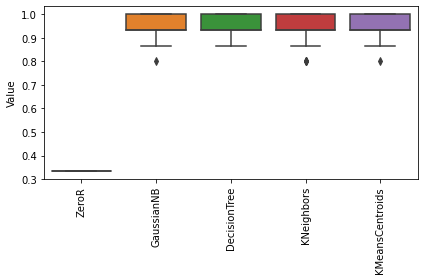

In [9]:
plt.figure()
sns.boxplot(data=DF)
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.tight_layout()
plt.show()

In [10]:
import scipy.stats as stats
M = [[-1]*len(ans) for _ in range(len(ans))]

for i in range(len(ans)):
    for j in range(i+1, len(ans)):
        # Calculate the t-test on TWO RELATED samples of scores, a and b.
        M[i][j] = stats.ttest_rel(DF.iloc[:,i], DF.iloc[:,j]).pvalue
        if any((DF.iloc[:,i] - DF.iloc[:,j]) != 0):
            # Calculate the Wilcoxon signed-rank test.
            M[j][i] = stats.wilcoxon(DF.iloc[:,i], DF.iloc[:,j]).pvalue
pd.DataFrame(M, index=DF.columns, columns=DF.columns)
# Reject when p-value is greater then 0.05

,ZeroR,GaussianNB,DecisionTree,KNeighbors,KMeansCentroids
ZeroR,-1.000000e+00,6.614062e-33,6.649577e-35,3.413305e-29,2.342430e-32
GaussianNB,1.074534e-06,-1.000000e+00,6.014763e-01,3.800729e-01,8.453803e-01
DecisionTree,9.877718e-07,5.929801e-01,-1.000000e+00,6.623618e-01,8.229733e-01
KNeighbors,1.150488e-06,3.604029e-01,6.353318e-01,-1.000000e+00,4.479307e-01
KMeansCentroids,1.128232e-06,7.824875e-01,8.509980e-01,4.385780e-01,-1.000000e+00
